# Yearbook Photo Grid Detection Using Amazon Nova Pro

This notebook demonstrates how to use **Amazon Nova Pro** to detect individual portrait photos in yearbook grid layouts.

Unlike generic figure detection algorithms, Nova Pro can understand natural language instructions like:
- "Detect individual portrait photos in this grid layout"
- "Find each student photo separately, even when they're close together"

By the end of this notebook, you'll be able to:
* Upload yearbook page images
* Detect individual portraits using Amazon Nova Pro
* Get accurate bounding boxes for each photo
* Visualize detection results with overlays

## Setup

Install required libraries and import dependencies.

In [1]:
!pip install boto3 pillow matplotlib --quiet

In [2]:
import boto3
import json
import base64
import io
from PIL import Image
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from textwrap import dedent

Configure the Amazon Nova Pro model. Ensure you have access to the model in your AWS region.

In [3]:
bedrock_runtime = boto3.client("bedrock-runtime", region_name="us-east-1")
MODEL_ID = "amazon.nova-pro-v1:0"

Verify model access.

In [4]:
try:
    response = bedrock_runtime.invoke_model(
        modelId=MODEL_ID,
        body=json.dumps({
            "messages": [{ "role": "user", "content": [ {"text": "Hello"} ] } ] }),
        contentType='application/json',
        accept='application/json'
    )
    print(f"✅ Model '{MODEL_ID}' is activated and available.")
except Exception as e:
    if "AccessDeniedException" in str(e) or "is not enabled" in str(e):
        print(f"❌ Model '{MODEL_ID}' is not activated.")
        print("🔗 Activate it here: https://console.aws.amazon.com/bedrock/home?modelaccess#/modelaccess")
    else:
        print(f"❌ Error: {e}")

✅ Model 'amazon.nova-pro-v1:0' is activated and available.


## Load Yearbook Image

Specify the path to your yearbook page image.

In [5]:
# Replace with your yearbook image path
yearbook_image_path = "./sample.jpg"

Helper functions for image processing.

✅ Loaded image: 751x500 pixels


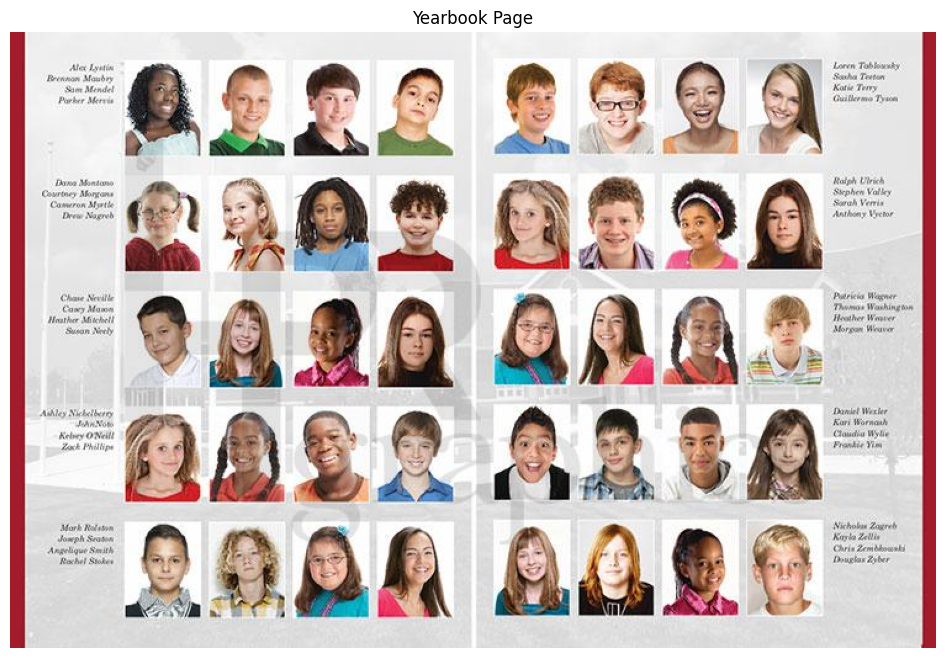

In [6]:
def load_image_as_base64(filepath, max_size=(2048, 2048)):
    """Load and encode image as base64 PNG."""
    img = Image.open(filepath)
    img.thumbnail(max_size, Image.Resampling.LANCZOS)
    
    with io.BytesIO() as output:
        img.save(output, format="PNG")
        png_bytes = output.getvalue()
        base64_str = base64.b64encode(png_bytes).decode("utf-8")
    
    return base64_str, png_bytes, img

# Load yearbook image
base64_image, image_bytes, img = load_image_as_base64(yearbook_image_path)
print(f"✅ Loaded image: {img.size[0]}x{img.size[1]} pixels")

# Display the image
plt.figure(figsize=(12, 8))
plt.imshow(img)
plt.axis('off')
plt.title("Yearbook Page")
plt.show()

## Define Detection Prompt

The prompt instructs Nova Pro to detect individual portrait photos and return structured bounding box data.

In [7]:
system_prompt = dedent("""\
    You are an expert at analyzing yearbook layouts and detecting individual portrait photographs.
    Your task is to identify each separate student portrait photo in the image, even when they are 
    arranged in dense grid layouts with minimal spacing between them.
    
    Focus on:
    - Individual portrait photos (headshots of students)
    - Accurate bounding boxes for each separate photo
    - Distinguishing between individual photos even in tight grids
""")

instruction = dedent("""\
    Detect all individual portrait photos in this yearbook page.
    
    Return a JSON response with this exact structure:
    {
        "total_photos": <number>,
        "photos": [
            {
                "id": "photo_1",
                "bounding_box": {
                    "x_min": <int>,
                    "y_min": <int>,
                    "x_max": <int>,
                    "y_max": <int>
                }
            }
        ]
    }
    
    Rules:
    - Detect EACH individual portrait separately
    - Provide accurate bounding boxes in pixel coordinates
    - Return clean JSON only (no markdown, no extra text)
    - Number photos sequentially (photo_1, photo_2, etc.)
""")

## Invoke Nova Pro for Detection

In [8]:
def detect_portraits(image_bytes, instruction, system_prompt):
    """Call Nova Pro to detect portrait photos."""
    request_body = {
        "schemaVersion": "messages-v1",
        "messages": [
            {
                "role": "user",
                "content": [
                    {"image": {"format": "png", "source": {"bytes": base64.b64encode(image_bytes).decode()}}},
                    {"text": instruction}
                ]
            }
        ],
        "system": [{"text": system_prompt}],
        "inferenceConfig": {
            "max_new_tokens": 4000,
            "temperature": 0.0,
            "top_p": 0.9
        }
    }
    
    try:
        response = bedrock_runtime.invoke_model(
            modelId=MODEL_ID,
            body=json.dumps(request_body)
        )
        model_response = json.loads(response["body"].read())
        print("✅ Detection completed successfully.")
        return model_response
    except Exception as e:
        print(f"❌ Error: {str(e)}")
        return None

def parse_detection_response(model_response):
    """Parse and clean the JSON response."""
    if not model_response:
        return None
    try:
        raw_text = model_response["output"]["message"]["content"][0]["text"]
        clean_json = raw_text.strip().replace("```json", "").replace("```", "").strip()
        parsed = json.loads(clean_json)
        print(f"✅ Detected {parsed.get('total_photos', 0)} photos")
        return parsed
    except Exception as e:
        print(f"❌ Parsing failed: {str(e)}")
        print(f"Raw response: {raw_text[:500]}")
        return None

# Run detection
model_response = detect_portraits(image_bytes, instruction, system_prompt)
detection_result = parse_detection_response(model_response)

if detection_result:
    print(json.dumps(detection_result, indent=2))

✅ Detection completed successfully.
✅ Detected 48 photos
{
  "total_photos": 48,
  "photos": [
    {
      "id": "photo_1",
      "bounding_box": {
        "x_min": 121,
        "y_min": 47,
        "x_max": 204,
        "y_max": 204
      }
    },
    {
      "id": "photo_2",
      "bounding_box": {
        "x_min": 214,
        "y_min": 48,
        "x_max": 296,
        "y_max": 204
      }
    },
    {
      "id": "photo_3",
      "bounding_box": {
        "x_min": 306,
        "y_min": 47,
        "x_max": 388,
        "y_max": 203
      }
    },
    {
      "id": "photo_4",
      "bounding_box": {
        "x_min": 397,
        "y_min": 48,
        "x_max": 480,
        "y_max": 204
      }
    },
    {
      "id": "photo_5",
      "bounding_box": {
        "x_min": 521,
        "y_min": 47,
        "x_max": 604,
        "y_max": 204
      }
    },
    {
      "id": "photo_6",
      "bounding_box": {
        "x_min": 614,
        "y_min": 47,
        "x_max": 697,
        "y_max": 

## Visualize Detection Results

Draw bounding boxes on the yearbook image.

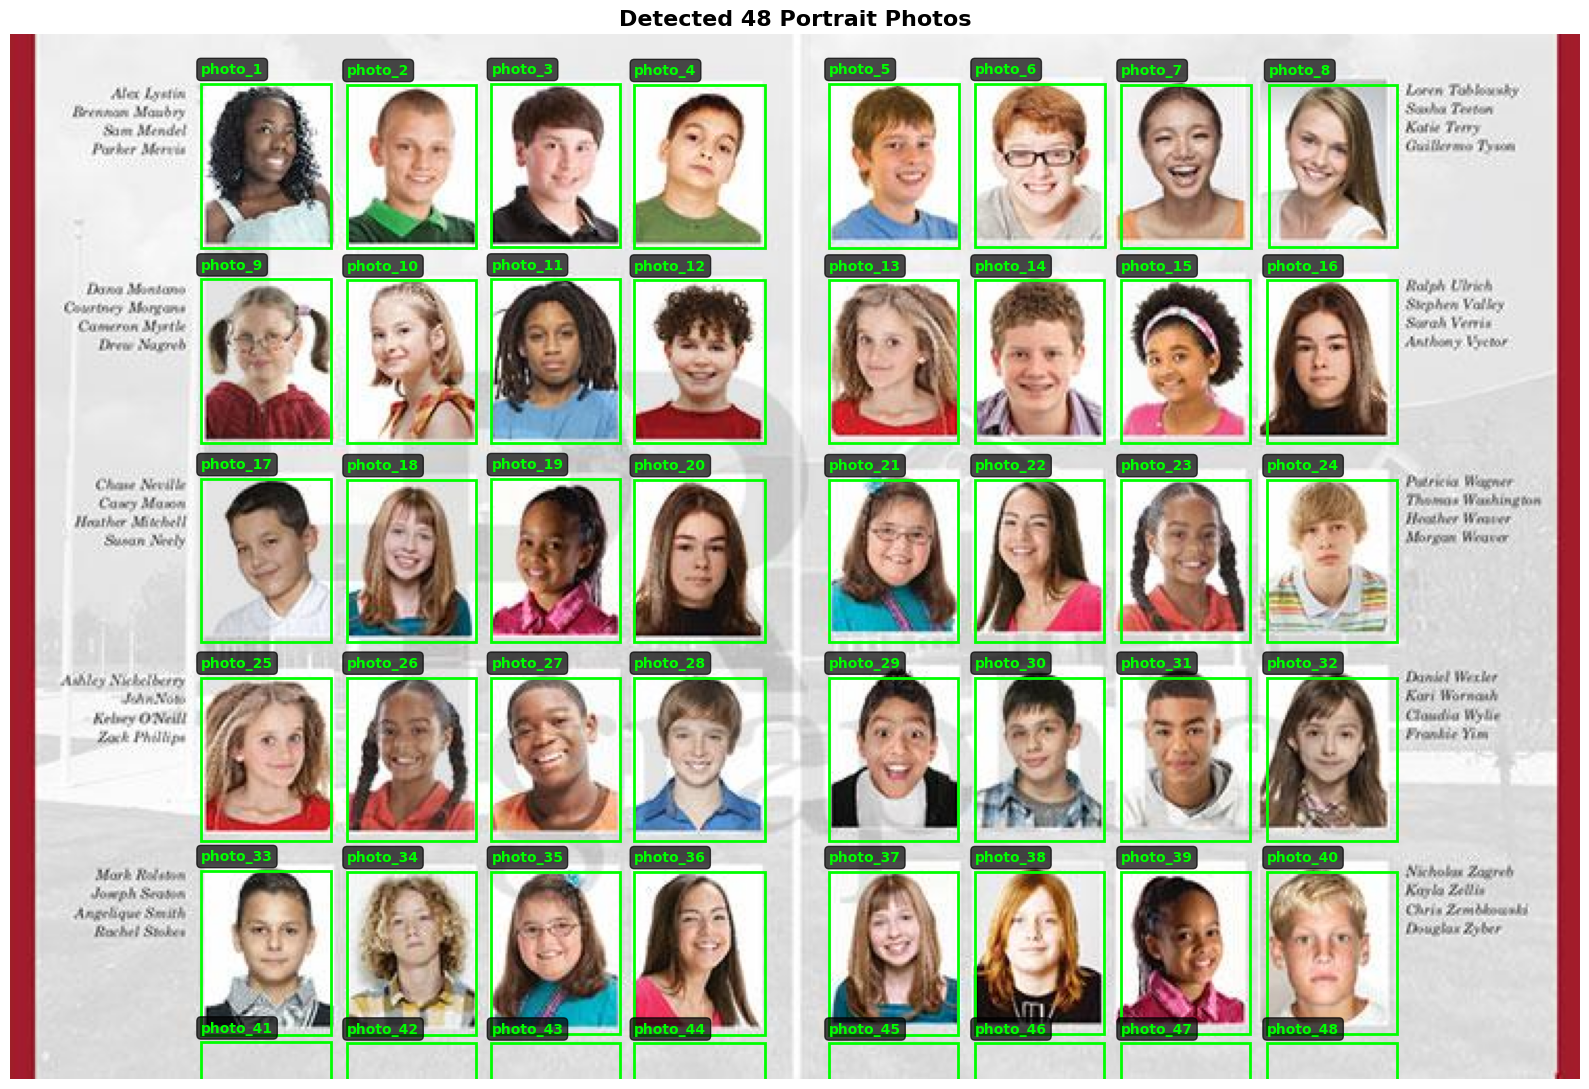

In [9]:
def visualize_detections(img, detection_result):
    """Draw bounding boxes on the image."""
    if not detection_result or 'photos' not in detection_result:
        print("No detections to visualize")
        return
    
    fig, ax = plt.subplots(figsize=(16, 12))
    ax.imshow(img)
    
    # Coordinate scaling (Nova Pro uses 1000x1000 normalized space)
    img_width, img_height = img.size
    scale_x = img_width / 1000
    scale_y = img_height / 1000
    
    for photo in detection_result['photos']:
        box = photo['bounding_box']
        x_min = box['x_min'] * scale_x
        y_min = box['y_min'] * scale_y
        x_max = box['x_max'] * scale_x
        y_max = box['y_max'] * scale_y
        
        width = x_max - x_min
        height = y_max - y_min
        
        rect = patches.Rectangle(
            (x_min, y_min), width, height,
            linewidth=2, edgecolor='lime', facecolor='none'
        )
        ax.add_patch(rect)
        
        ax.text(
            x_min, y_min - 5,
            photo['id'],
            color='lime', fontsize=10, weight='bold',
            bbox=dict(boxstyle='round,pad=0.3', facecolor='black', alpha=0.7)
        )
    
    plt.axis('off')
    plt.title(f"Detected {detection_result['total_photos']} Portrait Photos", fontsize=16, weight='bold')
    plt.tight_layout()
    plt.show()

# Visualize results
if detection_result:
    visualize_detections(img, detection_result)

## Export Bounding Box Coordinates

Save the detection results for downstream processing.

In [10]:
if detection_result:
    output_file = "yearbook_detections.json"
    with open(output_file, 'w') as f:
        json.dump(detection_result, f, indent=2)
    print(f"✅ Results saved to {output_file}")
    
    # Print summary
    print(f"\n📊 Detection Summary:")
    print(f"Total photos detected: {detection_result['total_photos']}")
    print(f"\nSample bounding boxes:")
    for photo in detection_result['photos'][:5]:
        box = photo['bounding_box']
        print(f"  {photo['id']}: ({box['x_min']}, {box['y_min']}) → ({box['x_max']}, {box['y_max']})")

✅ Results saved to yearbook_detections.json

📊 Detection Summary:
Total photos detected: 48

Sample bounding boxes:
  photo_1: (121, 47) → (204, 204)
  photo_2: (214, 48) → (296, 204)
  photo_3: (306, 47) → (388, 203)
  photo_4: (397, 48) → (480, 204)
  photo_5: (521, 47) → (604, 204)
